<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Colab/Shortest_Path_OpenStreetMap_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shortest Path on OSM Network

In [1]:
# Install dependencies, uncomment if required

!pip install geopandas
!pip install osmnx
!pip install pygeos

     |████████████████████████████████| 1.0 MB 16.7 MB/s 
     |████████████████████████████████| 6.3 MB 27.0 MB/s 
     |████████████████████████████████| 16.7 MB 4.7 MB/s 
     |████████████████████████████████| 95 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 11.2 MB 32.6 MB/s 
     |████████████████████████████████| 1.0 MB 52.4 MB/s 
     |████████████████████████████████| 900 kB 42.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires reque

     |████████████████████████████████| 2.1 MB 16.1 MB/s 


In [33]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 30.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires

/usr/local/lib/python3.7/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.7/dist-packages/matplotlib-3.1.3.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [1]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Helper Functions

In [2]:
# Function that gives back a plot with specific OSM network type

def osm_map(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, walk
    return map including origins, destinations, and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
        
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(14, 8), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin.plot(ax=ax, color='red')
    ax = destination.plot(ax=ax, color='blue')
    
    plt.axis('off')
    
    
    return ax

In [3]:
# Function that gives back the network as geodataframe

def osm_network(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, or walk
    return network <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    return edges

In [4]:
# Function that gives back the shortest path (It can have many origins and destinations)

def shortest_path(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return shortest path <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
            
            # Find all the shortests paths between the points - Optional
            # all_routes = nx.all_shortest_paths(graph_proj, source=closest_origin_node,target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']        

    # Set geometry
    routes = routes.set_geometry('geometry')
    
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    return routes    

In [5]:
# Function that gives back a plot with the shortest path
def shortest_path_map(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return map including origins, destinations, shortest path and network
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']
    
    # Set geometry
    routes = routes.set_geometry('geometry')
        
    # Set coordinate reference system
    routes.crs = nodes.crs

    
    plt.style.use('seaborn')
    
    # Plot
    ax = edges.plot(figsize=(16, 10), color='gray', linewidth=0.5, alpha=0.7)
    ax = origin_proj.plot(ax=ax, color='red')
    ax = destination_proj.plot(ax=ax, color='blue')
    ax = routes.plot(ax=ax, linewidth=3, alpha = 0.8, color = 'magenta')
    
    plt.axis('off')
    
    return ax

## Point to Point (Origin -> Destination)

In [6]:
# Create the Origin, Bola de Agua Landmark in Celaya

origin = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(-100.812060, 20.522047)
origin.at[0, 'name'] = 'Bola de Agua'
origin

,name,geometry
0,Bola de Agua,POINT (-100.81206 20.52205)


In [7]:
# Create the Destination, Acueducto Landmark in Queretaro
destination = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
destination.at[0, 'geometry'] = Point(-100.3726019, 20.5965238)
destination.at[0, 'name'] = 'Acueducto'
destination

,name,geometry
0,Acueducto,POINT (-100.37260 20.59652)


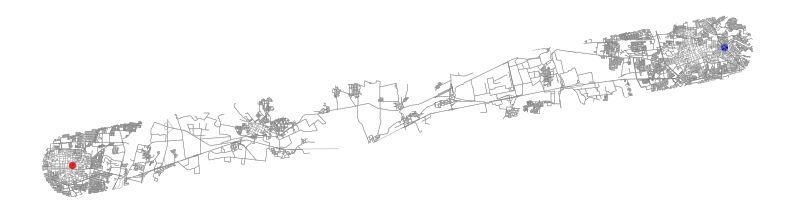

In [8]:
osm_map(origin, destination)
# plt.savefig('drive_network.png')

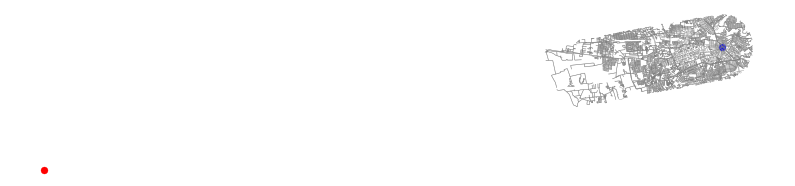

In [9]:
osm_map(origin, destination, 'bike')
# plt.savefig('bike_network.png')

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


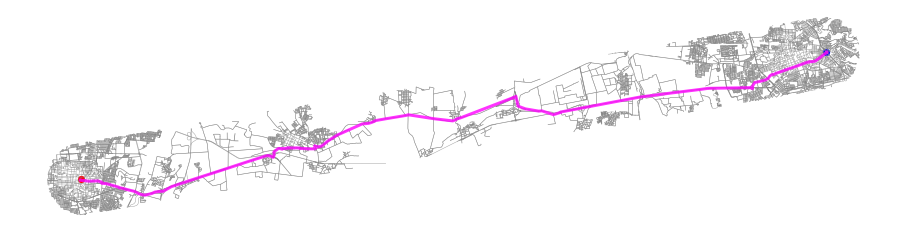

In [10]:
shortest_path_map(origin, destination, 'drive')
# plt.savefig('driving_network.png')

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


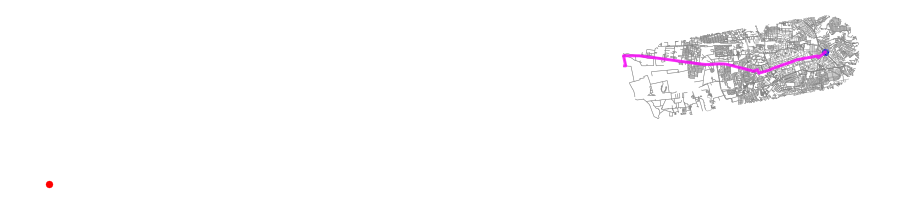

In [11]:
shortest_path_map(origin, destination, 'bike')
# plt.savefig('cycling_network.png')

In [12]:
drive_gdf = osm_network(origin, destination)
drive_gdf.head()
# drive_gdf.to_csv('drive.csv')

osmid  oneway lanes  \
u         v          key                                                    
294119813 2420407681 0                            186654629    True     3   
294119815 1580479684 0                            892766845    True     3   
294121692 294123209  0    [722514480, 311686298, 722514479]    True     2   
          3524488506 0     [722514483, 722514484, 27402438]    True     2   
294122038 1379558520 0                            304623228    True     5   

                              ref  \
u         v          key            
294119813 2420407681 0     MEX 45   
294119815 1580479684 0     MEX 45   
294121692 294123209  0    MEX 45D   
          3524488506 0        NaN   
294122038 1379558520 0    MEX 45D   

                                                                       name  \
u         v          key                                                      
294119813 2420407681 0                             Boulevard Constituyentes   
294119815 1580479684 0                               Avenida Constituyentes   
294121692 294123209  0    [Carretera Federal 57 México-Querétaro, Carret...   
          3524488506 0                      Calle Lateral Federal Número 57   
294122038 1379558520 0                         Carretera Querétaro - Celaya   

                            highway   length maxspeed  \
u         v          key                                
294119813 2420407681 0        trunk   78.181      NaN   
294119815 1580479684 0        trunk   51.990      NaN   
294121692 294123209  0     motorway  551.744       90   
          3524488506 0    secondary  165.277      NaN   
294122038 1379558520 0     motorway   52.601      NaN   

                                                                   geometry  \
u         v          key                                                      
294119813 2420407681 0    LINESTRING (-100.81097 20.50997, -100.81026 20...   
294119815 1580479684 0    LINESTRING (-100.79054 20.51724, -100.79005 20...   
294121692 294123209  0    LINESTRING (-100.39997 20.57433, -100.39936 20...   
          3524488506 0    LINESTRING (-100.39997 20.57433, -100.39966 20...   
294122038 1379558520 0    LINESTRING (-100.40104 20.57450, -100.40056 20...   

                         bridge width junction access tunnel  
u         v          key                                      
294119813 2420407681 0      NaN   NaN      NaN    NaN    NaN  
294119815 1580479684 0      NaN   NaN      NaN    NaN    NaN  
294121692 294123209  0      NaN   NaN      NaN    NaN    NaN  
          3524488506 0      NaN   NaN      NaN    NaN    NaN  
294122038 1379558520 0      NaN   NaN      NaN    NaN    NaN

In [13]:
route = shortest_path(origin, destination, 'drive')
route.head()

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


,geometry
0,"LINESTRING (311030.533 2270319.179, 311005.981..."


In [14]:
route.crs

<Projected CRS: +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Multiple Paths (Origin -> Amenities)

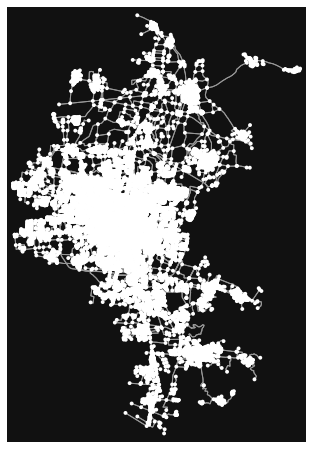

In [15]:
# fetching cafes as the destinations from OSM

# Specify the name that is used to seach for the data
place_name = 'Celaya, Guanajuato, Mexico'
# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
# Plot the streets
fig, ax = ox.plot_graph(graph)

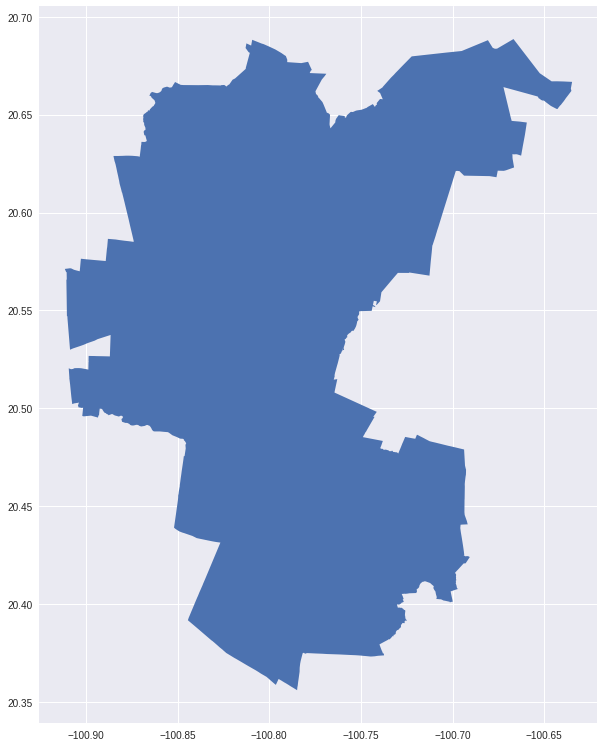

In [16]:
# Get place boundary related to the place name as a geodataframe

area = ox.geocode_to_gdf(place_name)
area.plot(figsize=(10,20));

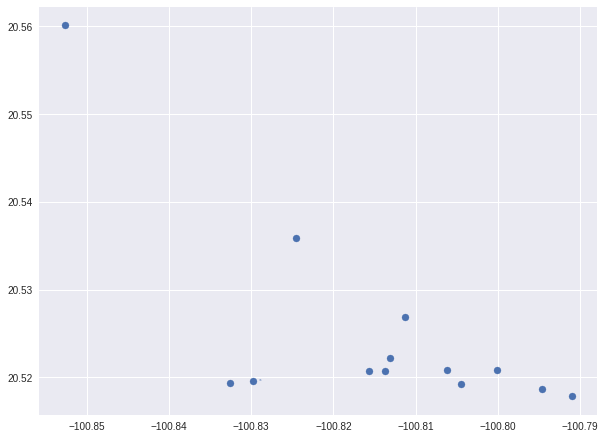

In [17]:
# List key-value pairs for tags

tags = {'amenity': 'cafe'}

# Get the data
cafes = ox.geometries_from_place(place_name, tags)

cafes.plot(figsize=(10,20));

In [18]:
cafes = cafes[['name', 'geometry']]
cafes = cafes.reset_index(drop=True)

# getting centroids from polygons to avoid polygon geometric objects
cafes['geometry'] = [geom.centroid for geom in cafes['geometry']]

print(len(cafes))
cafes.head(3)

14


,name,geometry
0,Peña del Angel,POINT (-100.81565 20.52079)
1,Italian Coffee,POINT (-100.82455 20.53594)
2,Caramel Coffee,POINT (-100.79463 20.51872)


In [19]:
routes = shortest_path(origin, cafes, network = 'walk')

/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/usr/local/lib/p

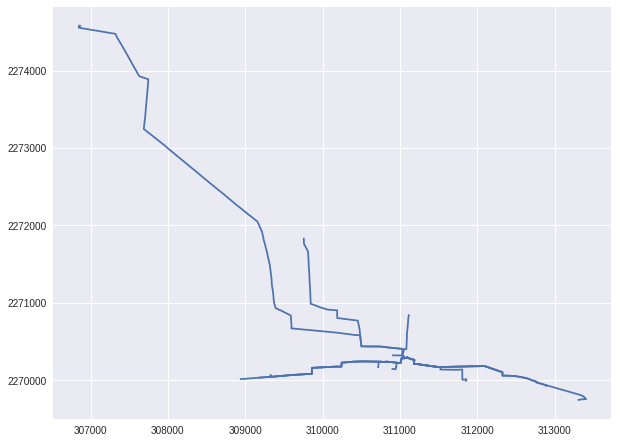

In [20]:
routes.plot(figsize=(10,20));

In [21]:
len(routes)

14

In [22]:
routes.crs

<Projected CRS: +proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
routes['distance'] = routes['geometry'].length

routes.head()

,geometry,distance
0,"LINESTRING (311054.979 2270288.703, 311051.499...",473.921854
1,"LINESTRING (311054.979 2270288.703, 311043.049...",2584.821411
2,"LINESTRING (311054.979 2270288.703, 311070.584...",2014.671195
3,"LINESTRING (311054.979 2270288.703, 311070.584...",1352.820162
4,"LINESTRING (311054.979 2270288.703, 311043.049...",608.049393


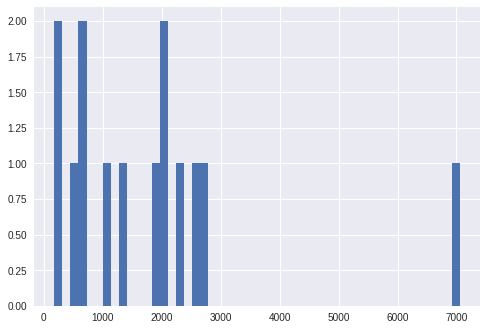

In [24]:
plt.style.use('seaborn')
routes['distance'].hist(bins=50);

In [25]:
routes_wgs = routes.to_crs(4326)

In [26]:
routes_wgs.to_file(r'walking_routes.geojson', driver='GeoJSON')
cafes.to_file(r'cafes.geojson', driver='GeoJSON')
origin.to_file(r'origin.geojson', driver='GeoJSON')
area.to_file(r'city_area.geojson', driver='GeoJSON')

In [27]:
walking_network = osm_network(origin, cafes, network = 'walk')

In [28]:
walking_network = walking_network[['geometry']]
walking_network = walking_network.reset_index(drop=True)

walking_network.head()

,geometry
0,"LINESTRING (-100.81097 20.50997, -100.81026 20..."
1,"LINESTRING (-100.81097 20.50997, -100.81119 20..."
2,"LINESTRING (-100.81097 20.50997, -100.81118 20..."
3,"LINESTRING (-100.79054 20.51724, -100.79005 20..."
4,"LINESTRING (-100.79054 20.51724, -100.79070 20..."


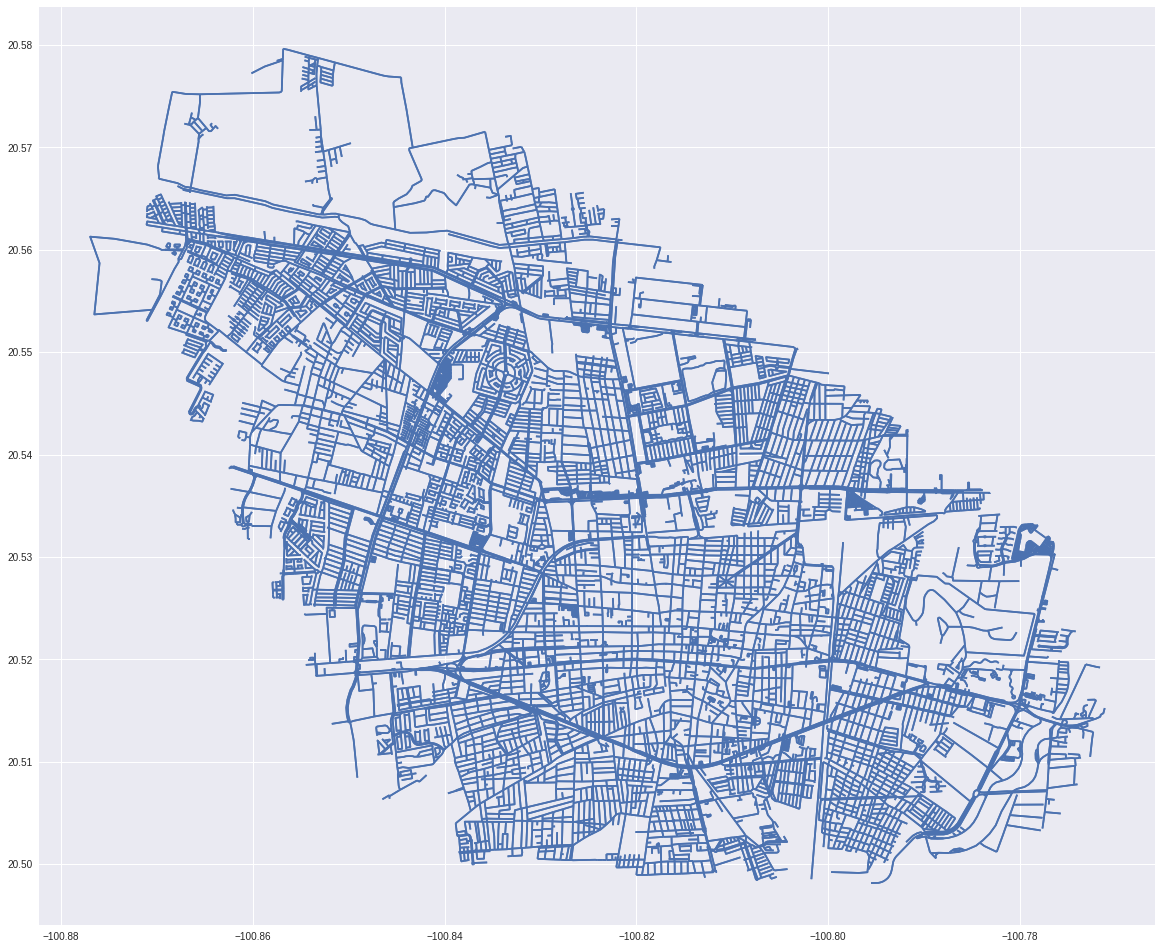

In [29]:
walking_network.plot(figsize=(20,40));

In [30]:
walking_network.to_file(r'walk_network.geojson', driver='GeoJSON')